# 比对性测试

## 概念

### ***CommonNarsese***

- 由[Narsese Grammar (IO Format)](https://github.com/opennars/opennars/wiki/Narsese-Grammar-(Input-Output-Format))定义，
- 在各类NARS(Narsese)实现中，
- 最先产生规范，并最为广泛接受的一种语法

与其它方言、超集的不同点举例：
- 原子词项：
    - 一律使用`$`、`#`、`?`、`^`区分「独立变量」「非独变量」「查询变量」「操作」
    - 一律使用单独的`_`表示「像占位符」
- 复合词项：
    - 一律使用特殊括弧`{词项...}`、`[词项...]`表示「外延集」「内涵集」
    - 一律使用「圆括号+前缀表达式」`(连接符, 词项...)`形式表示「非外延集、内涵集的复合词项」
        - 如`(&, <A --> B>, ^op)`
        - 对「否定」不使用前缀表达式
        - 对其它「二元复合词项」不使用中缀表达式
- 陈述：
    - 一律使用尖括号表示陈述，没有其他选项
        - 如`<A --> B>`
    - 不使用「回顾性等价」`<\>`系词
        - 一律用表义能力等同的「预测性等价」`</>`系词代替
        - 如`<A <\> B>`将表示为`<B </> A>`


## 导入

In [1]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

JuNarsese v2.6.1


In [2]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [3]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 3


4

In [4]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [5]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

randomTruth() = JuNarsese.default_precision_truth(rand(0.01:0.01:0.99, 2)...)
randomBudget() = JuNarsese.default_precision_budget(rand(0.01:0.01:0.99, 3)...)
randomTense() = @rand [
    TensePast
    TensePresent
    TenseFuture
    TenseEternal
]

randomStamp() = JuNarsese.StampBasic{randomTense()}() # 暂仅支持随机时态

function random_wrap_sentence(term::Term)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(term; truth = randomTruth(), stamp = randomStamp())
end

function random_wrap_task(sentence::ASentence)
    TaskBasic(sentence; budget = randomBudget())
end

randomSentence(depth=3, width=3) = random_wrap_sentence(randomStatement(depth-1, width))
randomTask(depth=3, width=3) = random_wrap_task(randomSentence(depth-1, width))


function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
        randomTask(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 <(-, #xtmbvcwvvn, $acs) <-> #uuqpycqk>
 (-, (|, ^fbnk), (--, <#idyaoribrz <-> $lqvnhwr>))
 $0.31;0.12;0.8$ <<<?c <-> #tobvsypbrn> <=> <iyarciyee --> ?slxyfaylo>> ==> <?ezmbzing <-> $okrnwoe>>?
 (--, <<[aibvnnwwy, #rsybjp, ^uvbvq, ?xznyf, #zpghy] --> (~, ^jkxxl, #eisig)> ==> <(\, _, rqpqlzambt) --> (-, $fjxmycyr, ^ja)>>)
 $0.37;0.64;0.04$ <(/, _, #s, zw) --> (\, _, $xh, rpha, ?hnftkfpvkd, ^agbyo, ?mfyecesgd)>! :|: %0.7;0.01%
 <(~, dfpbsbfrvm, ?av) <-> (\, hjd, ^zuajo, l, efjjbsh, _, $poshgxejws)>@ :/:
 $0.2;0.28;0.71$ <<<^qkxm <-> #x> ==> <#xxguwjp --> ?m>> ==> <<#cgj <-> ^xhyvabgtju> ==> <#ksc <-> $nzitub>>>@ :|:
 <#mlxcwxwx --> rsbw>
 $0.59;0.35;0.26$ <(*, poojmm, $hobj, vjxjzdwbci, ^xdvpeal) <-> (~, $r, ?gzwuehai)>. :\: %0.97;0.85%
 $0.54;0.04;0.13$ <(~, #wgsa, ^q) <-> ?akrn>? :|:

生成测试集

In [6]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 先生成随机词项，然后再将部分词项修改成语句、任务
    for _ in 1:N
]

randomNarsese(D, W) = $0.83;0.23;0.11$ <<(-, (--, <$wvm <-> $y>), (--, <<gkgxjosom <-> xqnfpln> <=> <nbqkikswvk <-> $vtabolvmus>>)) --> ivohhpn> <=> <(|, <$nobwp <-> #pastuykfsa>) --> #uolrl>>@ :/:


500-element Vector{AbstractTerm}:
 (\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))
 (--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, 

## 评估函数

#### 导入数据分析工具：DataFrames

In [7]:
using DataFrames

测试：使用具名元组直接添加行

In [8]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


#### 构造测试用表

In [9]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

Row,original_term,string
,Abstract…,String
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))"
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)"
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>"
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhcunztg, kfp) <-> (/, _, ygp

In [10]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>",29
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhc

#### 增加「非CommonNarsese语法」：更能体现出解析器通用性的语法

1. 无连接符复合词项⇒乘积：`(A, B)`⇔`(*, A, B)`

In [11]:
# 无连接符复合词项⇒乘积 #
# 📝直接使用「布尔索引」对切片进行操作

# 使用 map() 函数对 test_set_extra1 中的 string 列进行操作，返回一个新数据表
# 将其中符合正则表达式 r"\(\*\W*," 的字符串替换为 "(*,"
test_set_extra1_string = map(test_set.string) do x
    replace(x, r"\(\*\W*," => "(*,")
end

# 使用「布尔索引」来选择不等于原始 string 列的值
# 并将这些值替换为经过操作后的新值
# 注意：.≠ 运算符用于逐元素比较两个数组，生成一个布尔型数组
# test_set_extra1.string[test_set_extra1! .≠ test_set_extra1.string] = test_set_extra1![test_set_extra1! .≠ test_set_extra1.string]

#【20230819 20:07:04】现在直接把「能改成新格式」的数据增加到主数据集中
indices = test_set_extra1_string .≠ test_set.string # 索引：只获取「会被改变的词项」

test_set_extra1 = test_set[indices, :] |> deepcopy

test_set_extra1.string = test_set_extra1_string[indices]

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra1
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>",29
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhc

2. 随机添加空白字符：空格` `、换行`\r`、回车`\n`、换页`\f`、水平制表符`\t`、垂直制表符`\v`

In [12]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>",29
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhc

3. 按一定比例随机选取词项，提升成**语句**、**任务**（遵循CommonNarsese语法）
- 这样可以保留语法复杂度等信息

In [13]:
# 随机选取行
rand_sentences = DataFrame(rand(eachrow(test_set), 100))
rand_tasks = DataFrame(rand(eachrow(test_set), 100
))

# 打包，原地赋值
rand_sentences.original_term = rand_sentences.original_term .|> random_wrap_sentence
rand_tasks.original_term = rand_tasks.original_term .|> random_wrap_sentence .|> random_wrap_task

# 更新字符串
rand_sentences.string = string.(rand_sentences.original_term)
rand_tasks.string = string.(rand_tasks.original_term)

test_set = [ # 拼接
    test_set # 原本
    rand_sentences
    rand_tasks
]

Row,original_term,string,complexity
,Any,String,Int64
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>",29
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhcunztg,

In [14]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Any,String,Int64
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>",29
4,"(\\, (--, <<<(~, $ttculofhf, #zyz) --> (\\, qh, #i, ?qmhdmo, #cxdcz, lzagmtujd, _)> <=> <<$p --> #byh> ==> <<^rhx --> $ossznm> ==> <pxqrnq <-> qsoizhu>>>> ==> <<<<nyqrmrpax <-> ?vwyruwjoj> ==> <czb --> nxbnt>> <=> <<#xbkasq --> dspbbx> ==> <?ntme --> $uwli>>> ==> <^jhgygtgtno <-> $wol>>>), <<<(\\, _, #hgiyds, ieizu) <-> (\\, ?arcq, _, $aellhkj)> <=> <<#cilydt <-> #zfcslselt> <=> <kyoybhsxr --> #cdod>>> ==> <<<^d <-> jgpli> <=> <#lklhfwkdm <-> $xjyxkvlsia>> ==> <<<?mr --> ?idfr> <=> <^oprhensgx --> #alpujcbbls>> ==> <<$vibwybfz --> ?bnqsnt> ==> <gzfngyi <-> #wamcpvr>>>>>, (~, (-, <<$ahxjjb <-> ^gmaqhw> <=> <lnthlb --> #nemhv>>, <#cquaowk <-> $fvpwljjvb>), (--, <<#jcmikivfc <-> ylkdkfl> <=> <?xq --> $cmvmbidr>>)), (--, <<<<^jqtbpisldu <-> ^xlwibphz> <=> <<$fxdkhdyxgn <-> $wrtycu> ==> <$c <-> ecpjcfdf>>> ==> <(\\, #a, ?ldawg, _, ?f, ?vdjxac, $vq) --> (~, #ogdvddxo, ^tp)>> <=> <?avwcxzeh --> (\\, #juhtviki, o, uruksdk, _)>>), (-, <(-, fhcunztg,

#### 构造评估函数

In [15]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "$(parser)：以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [16]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",1.35965,missing
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",0.26526,missing
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> t

In [17]:
# 导入OpenJunars
isdefined(Main, :Junars) || begin
    push!(LOAD_PATH, "../../../OpenJunars/")
    import Junars
end
# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
@info "OpenJunars解析结果:" parsed_term typeof(parsed_term)

┌ Info: OpenJunars解析结果:
│   parsed_term = "<A-->B>"
└   typeof(parsed_term) = Junars.Gene.Inheritance


In [18]:
testParser!(Junars.parse_term, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))","(\\, _, (--, <<<<$xobjbitadk <-> ?xyw> <=> <<^lppuorg --> $g> <=> <?ydtejmpqii --> uhynfqmg>>> ==> <<<#ffqfb --> yhzr> <=> <^mlebhlrw --> ?huo>> <=> <?mj --> ?akyy>>> ==> <^x --> (|, bilovuqkzn, $hpmvsk, #vzobfmq, $xycw)>>), (\\, <(/, _, dsy, #tjajb, $ih, #tx) <-> ?g>, <<<jkvsnseiq <-> ?mvqyvi> ==> <ups --> dejmyhxpqf>> ==> <<^cid <-> $dxg> <=> <qoylujtk <-> #trrotlwrdq>>>, (&, (|, #dcdo, ^fifjuw, ?gonmfdvx, $qvgt, tuxgtyuz, $wfamjyuqfp, ^wlzhfhkdfi, ^xtpjusautg), (--, <^tjqjla --> #qiasjrez>), <?dxkflhhrz <-> ^llzn>, <?i <-> $lzb>, <^qay <-> r>), (~, (\\, _, $hyrjjsqfe, ^idajgdzg), (--, <<#feaawhm --> vxqsumzucc> <=> <^jnxelqeamx <-> ^ykfkpu>>)), <(\\, _, ?deqw, #quqtbqqlw) <-> ^jqrfhwddb>, <?ijddfy --> $feypdvy>, (--, <(~, wu, xirhdrwb) --> (~, ?urlw, ?vbkebva)>), _))",73,"""(\\\\,_,(¬,<<<<\\$xobjbitadk<->?xyw><=><<?ydtejmpqii-->uhynfqmg><=><^lppuorg-->\\$g>>>==><<<#ffqfb-->yhzr><=><^mlebhlrw-->?huo>><=><?mj-->?akyy>>>==><^x-->(|,#vzobfmq,\\$hpmvsk,\\$xycw,bilovuqkzn)>>),(\\\\,<(/,_,dsy,#tjajb,\\$ih,#tx)<->?g>,<<<?mvqyvi<->jkvsnseiq>==><ups-->dejmyhxpqf>>==><<#trrotlwrdq<->qoylujtk><=><\\$dxg<->^cid>>>,(&,(|,#dcdo,\\$qvgt,\\$wfamjyuqfp,?gonmfdvx,^fifjuw,^wlzhfhkdfi,^xtpjusautg,tuxgtyuz),(¬,<^tjqjla-->#qiasjrez>),<\\$lzb<->?i>,<?dxkflhhrz<->^llzn>,<^qay<->r>),(~,(\\\\,_,\\$hyrjjsqfe,^idajgdzg),(¬,<<#feaawhm-->vxqsumzucc><=><^jnxelqeamx<->^ykfkpu>>)),<(\\\\,_,?deqw,#quqtbqqlw)<->^jqrfhwddb>,<?ijddfy-->\\$feypdvy>,(¬,<(~,wu,xirhdrwb)-->(~,?urlw,?vbkebva)>),_))""",2.12222,missing
2,"(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)","(--, <<(*, (--, <$fprlrfqp <-> ^lhk>), <<$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, $cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, $dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> $siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <$ljbhpvt --> ?xhlvhtz>]>>)",39,"""(¬,<<(*,(¬,<\\$fprlrfqp<->^lhk>),<<\\$grxqiql-->b><=><^zgfsphllo-->^up>>)-->{(&,#nhnym,\\$cakspxrckt,^gvym,^wr,nocjuzztep),(&,#qdyumw,#vpcaurqy,^xnetnunkch),(|,\\$dbvzs,?uq,?vcyl,kirqv,mybbeketzd),<#huz-->?vtwkznm>,<?qlqm-->?qgdtmphpjl>}><=><^ktfn-->[(~,?xyqujhxg,^opnzxp),(¬,<#njqkulaa-->dtaejj>),(¬,<<#cdutnucla-->\\$siza>==><^nvnyzn-->?mkl>>),<\\$ljbhpvt-->?xhlvhtz>]>>)""",0.426568,missing
3,"<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u> ==> <^dofjsiw --> njetad>>>, <<#jhdv --> $btwf> ==> <#bivnjiezg <-> hnpr>>, (\\, _, (~, $bmpnlqvuy, ?rbgpgpkdi), <?qk --> ?cizyslcb>, (--, <tjrolhqwr --> toswvnnqd>), (~, #viumh, $foygcsuirb)))>","<^qp --> (\\, _, (--, <(-, ?h, ^miqqt) --> ^kp>), <<#lug --> $efv> <=> <<ap --> u>

## 对比性评估开始

In [19]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term  => "Junars",
    StringParser_ascii => "JuNarsese-Native",
    LarkParser_alpha   => "JuNarsese×Lerche",
    PikaParser_alpha   => "JuNarsese×PikaParser",
    PikaParser_ascii   => "JuNarsese-Native×PikaParser",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: PikaParser_alpha：以下39项解析错误：
│   errors =
│    39-element Vector{Union{Missing, Exception}}:
│     ErrorException("PikaParser_alpha: 解析「(--, <<(*, <\$fprlrfqp <-> ^lhk>), <<\$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, \$cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, \$dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> \$siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <\$ljbhpvt --> ?xhlvhtz>]>>)((--, <<(*, <\$fprlrfqp <-> ^lhk>), <<\$grxqiql --> b> <=> <^zgfsphllo --> ^up>>) --> {(&, \$cakspxrckt, ^gvym, #nhnym, nocjuzztep, ^wr), (|, \$dbvzs, kirqv, mybbeketzd, ?uq, ?vcyl), (&, #qdyumw, #vpcaurqy, ^xnetnunkch), <#huz --> ?vtwkznm>, <?qlqm --> ?qgdtmphpjl>}> <=> <^ktfn --> [(--, <#njqkulaa --> dtaejj>), (--, <<#cdutnucla --> \$siza> ==> <^nvnyzn --> ?mkl>>), (~, ?xyqujhxg, ^opnzxp), <\$ljbhpvt --> ?xhlvhtz>]>>))」失败！match 

Dict{Any, Any} with 5 entries:
  PikaParser_alpha   => 946×6 DataFrame…
  LarkParser_alpha   => 946×6 DataFrame…
  PikaParser_ascii   => 946×6 DataFrame…
  parse_term         => 946×6 DataFrame…
  StringParser_ascii => 946×6 DataFrame…

## 比对结果分析、展示

In [20]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [21]:
print("解析成功的数据：")
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

解析成功的数据：

5-element Vector{Pair{_A, Int64} where _A}:
          PikaParser_alpha => 907
          LarkParser_alpha => 630
          PikaParser_ascii => 907
 Junars.Control.parse_term => 807
        StringParser_ascii => 895

In [22]:
using CairoMakie

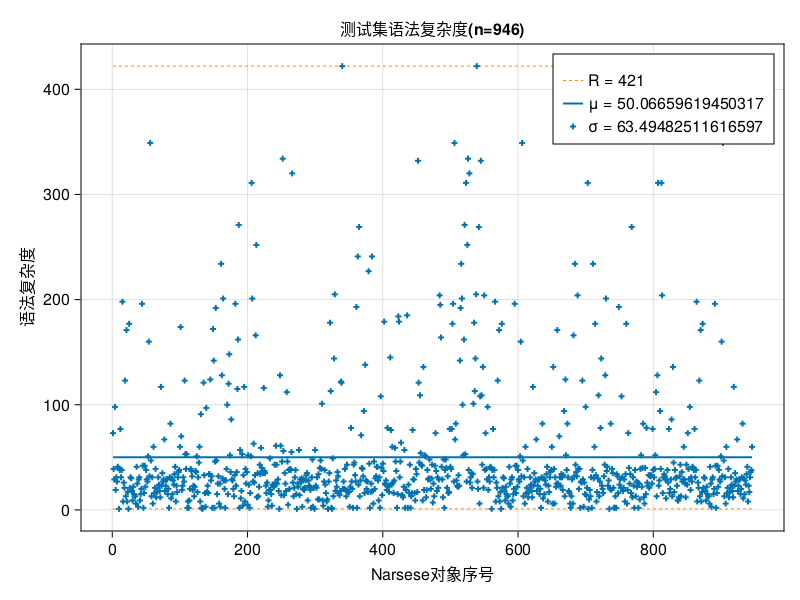

In [23]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度(n=$(size(test_set, 1)))"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "语法复杂度"

current_figure()

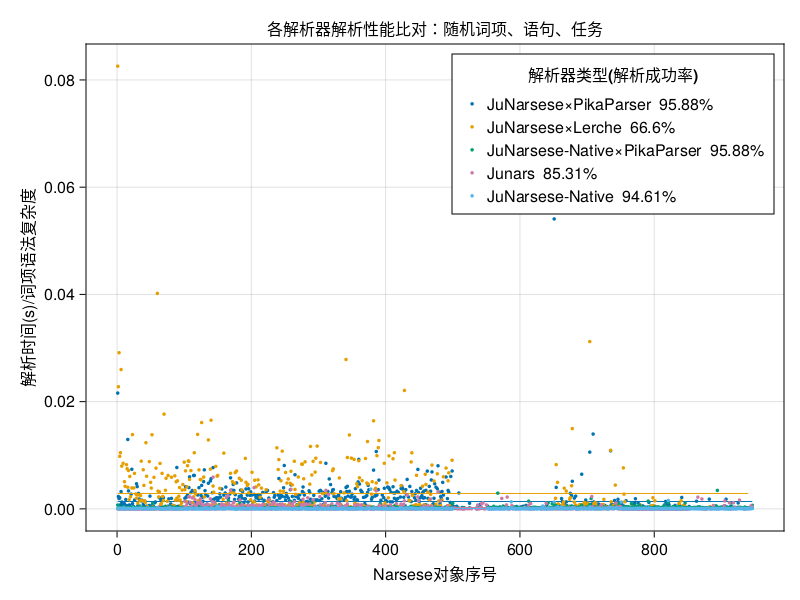

In [24]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

μₜ(JuNarsese×PikaParser) = -3.2568433531114267
μₜ(JuNarsese×Lerche) = -3.1241458687645935
μₜ(JuNarsese-Native×PikaParser) = -3.6694232306158936
μₜ(Junars) = -4.493611406277317
μₜ(JuNarsese-Native) = -4.282851965226358


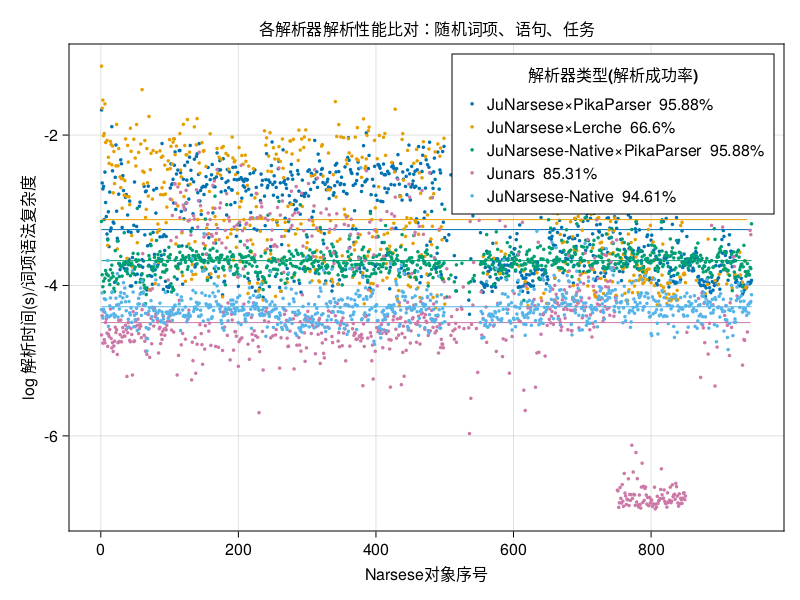

In [25]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    "μₜ($(parser_names[parser])) = $mean_ys" |> println
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()